In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import tqdm
from blitz.modules import BayesianLinear, BayesianConv1d
from blitz.utils import variational_estimator
# 需要安装库：conda install -c conda-forge blitz-bayesian-pytorch
'''
本文件实现了基于贝叶斯神经网络（Bayesian Neural Network，BNN）的时序预测模型。
'''


'\n本文件实现了基于贝叶斯神经网络（Bayesian Neural Network，BNN）的时序预测模型。\n'

In [2]:
# 超参数
# 定义训练参数
num_epochs = 10  # 训练的轮数
learning_rate = 0.01 # 学习率
num_samples = 1000  # 样本总数
input_len = 64 # 输入长度
output_len = 16  # 输出长度
input_channels = 8  # 输入通道数
output_channels = 4  # 输出通道数
batch_size = 32  # 批大小


# 定义一个简单的贝叶斯神经网络
@variational_estimator
class BNN_conv1d(nn.Module):
    '''
    (batch_size, input_len, input_channels) -> (batch_size, output_len, output_channels)
    '''
    def __init__(self, input_len=64, output_len=16, input_channels=8, output_channels=8, kernel_size=3, padding=1):
        super(BNN_conv1d, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.input_channels = input_channels
        self.output_channels = output_channels

        self.conv1 = BayesianConv1d(in_channels=input_channels, out_channels=input_channels ,kernel_size=kernel_size, padding=padding)
        self.conv2 = BayesianConv1d(in_channels=input_channels, out_channels=input_channels ,kernel_size=kernel_size, padding=padding)
        self.fc=BayesianLinear(in_features=input_channels*input_len//4, out_features=output_channels*output_len)
    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch_size, input_len, input_channels) -> (batch_size, input_channels, input_len)
        x = self.conv1(x) # (batch_size, input_channels, input_len) -> (batch_size, input_channels, input_len)
        x = nn.MaxPool1d(kernel_size=2)(x) # (batch_size, input_channels, input_len) -> (batch_size, input_channels, input_len//2)
        x = nn.functional.relu(x)
        x = self.conv2(x) # (batch_size, input_channels, input_len//2) -> (batch_size, input_channels, input_len//2)
        x = nn.MaxPool1d(kernel_size=2)(x) # (batch_size, input_channels, input_len//2) -> (batch_size, input_channels, input_len//4)
        x = x.view(x.size(0), -1) # (batch_size, input_channels, input_len//4) -> (batch_size, input_channels*input_len//4)
        x = self.fc(x) # (batch_size, input_channels*input_len//4) -> (batch_size, output_channels*output_len)
        x = x.view(x.size(0), self.output_len, self.output_channels) # (batch_size, output_channels*output_len) -> (batch_size, output_len, output_channels)
        return x





In [3]:
import mydatasets
import random
# 加载测试数据集
X, Y = mydatasets.load_test_data(id='2',
                                input_dim=(num_samples, input_len, input_channels),
                                output_dim=(num_samples, output_len, output_channels),
                                noise=0.2)

# 自定义数据集类
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X # shape: (num_samples, input_len, input_channels)
        self.Y = Y # shape: (num_samples, output_len, output_channels)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 构建数据集
indices=list(range(num_samples))
random.shuffle(indices)

train_ratio=0.7 # 训练集占比
val_ratio=0.1 # 验证集占比
test_ratio=0.2 # 测试集占比

num_train=int(train_ratio*num_samples)
num_val=int(val_ratio*num_samples)
num_test=int(test_ratio*num_samples)
assert num_train+num_val+num_test<=num_samples

train_indices=indices[:num_train]
val_indices=indices[num_train:num_train+num_val]
test_indices=indices[num_train+num_val:num_train+num_val+num_test]

train_dataset = TimeSeriesDataset(X[train_indices], Y[train_indices])
val_dataset = TimeSeriesDataset(X[val_indices], Y[val_indices])
test_dataset = TimeSeriesDataset(X[test_indices], Y[test_indices])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 实例化模型、损失函数、评估函数和优化器
model = BNN_conv1d(input_len=input_len, input_channels=input_channels, output_len=output_len, output_channels=output_channels)
loss_func = nn.MSELoss() # MSE，用于拟合
metric_func=nn.L1Loss() # MAE，用于评估
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Train dataset size: X: ({num_train}, {input_len}, {input_channels}); Y: ({num_train}, {output_len}, {output_channels})")
print(f"Val dataset size: X: ({num_val}, {input_len}, {input_channels}); Y: ({num_val}, {output_len}, {output_channels})")
print(f"Test dataset size: X: ({num_test}, {input_len}, {input_channels}); Y: ({num_test}, {output_len}, {output_channels})")

Train dataset size: X: (700, 64, 8); Y: (700, 16, 4)
Val dataset size: X: (100, 64, 8); Y: (100, 16, 4)
Test dataset size: X: (200, 64, 8); Y: (200, 16, 4)


In [4]:
# 训练模型
fit_history=[]
total_time=0.0 # 总训练时间
for epoch in range(num_epochs):
    t1=time.time() # 该轮开始时间
    train_loss, train_metric = 0.0, 0.0 # 本轮的训练loss和metric
    val_loss, val_metric = 0.0, 0.0 # 本轮的验证loss和metric

    # 训练
    model.train() # 切换到训练模式
    for inputs, targets in train_loader: # 分批次遍历训练集
        optimizer.zero_grad() # 清空梯度
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        metric = metric_func(outputs, targets)
        loss.backward() # 反向传播
        optimizer.step() # 更新权重
        train_loss+=loss.item()
        train_metric+=metric.item()
    
    # 验证
    model.eval() # 切换到验证模式
    with torch.no_grad(): # 关闭梯度计算
        for inputs, targets in val_loader: # 分批次遍历验证集
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            metric=metric_func(outputs, targets)
            val_loss+=loss.item()
            val_metric+=metric.item()
    
    # 计算各指标的平均值
    average_train_loss=train_loss/len(train_loader) # 本轮的平均训练loss
    average_train_metric=train_metric/len(train_loader) # 本轮的平均训练metric
    average_val_loss=val_loss/len(val_loader) # 本轮的平均验证loss
    average_val_metric=val_metric/len(val_loader) # 本轮的平均验证metric

    # 记录本轮各指标值
    fit_history.append((average_train_loss, average_train_metric, average_val_loss, average_val_metric))

    t2=time.time() # 该轮结束时间
    total_time+=(t2-t1) # 累计训练时间

    # 输出过程信息
    message=f'Epoch [{str(epoch + 1).center(4, " ")}/{num_epochs}], Time: {(t2-t1):.4f}s'
    message+=f', Loss: {average_train_loss:.4f}'
    message+=f', Metric: {average_train_metric:.4f}'
    message+=f', Val Loss: {average_val_loss:.4f}'
    message+=f', Val Metric: {average_val_metric:.4f}'
    print(message)
print(f'Total Time: {total_time:.4f}s')

Epoch [ 1  /10], Time: 0.2074s, Loss: 0.2147, Metric: 0.3104, Val Loss: 0.0518, Val Metric: 0.1814
Epoch [ 2  /10], Time: 0.1493s, Loss: 0.0445, Metric: 0.1684, Val Loss: 0.0423, Val Metric: 0.1628
Epoch [ 3  /10], Time: 0.1761s, Loss: 0.0413, Metric: 0.1623, Val Loss: 0.0412, Val Metric: 0.1613
Epoch [ 4  /10], Time: 0.1498s, Loss: 0.0408, Metric: 0.1612, Val Loss: 0.0411, Val Metric: 0.1618
Epoch [ 5  /10], Time: 0.1438s, Loss: 0.0410, Metric: 0.1616, Val Loss: 0.0413, Val Metric: 0.1618
Epoch [ 6  /10], Time: 0.1483s, Loss: 0.0411, Metric: 0.1619, Val Loss: 0.0411, Val Metric: 0.1614
Epoch [ 7  /10], Time: 0.1498s, Loss: 0.0408, Metric: 0.1613, Val Loss: 0.0417, Val Metric: 0.1623
Epoch [ 8  /10], Time: 0.1533s, Loss: 0.0413, Metric: 0.1622, Val Loss: 0.0410, Val Metric: 0.1605
Epoch [ 9  /10], Time: 0.1432s, Loss: 0.0416, Metric: 0.1629, Val Loss: 0.0420, Val Metric: 0.1631
Epoch [ 10 /10], Time: 0.1533s, Loss: 0.0409, Metric: 0.1615, Val Loss: 0.0411, Val Metric: 0.1616
Total Time

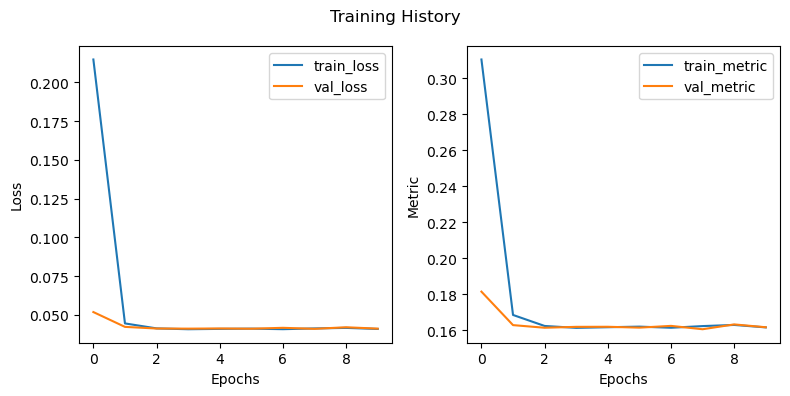

In [5]:
fit_history =np.array(fit_history)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(fit_history[:,0], label='train_loss')
plt.plot(fit_history[:,2], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fit_history[:,1], label='train_metric')
plt.plot(fit_history[:,3], label='val_metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.suptitle("Training History")
plt.legend()

plt.tight_layout() # 调整子图间距，防止重叠
plt.bbox_inches='tight' # 确保保存时图片不丢失边界区域
# plt.savefig('training_history.png', dpi=300) # 保存图片
plt.show()

MSE on sample 561: 0.0407


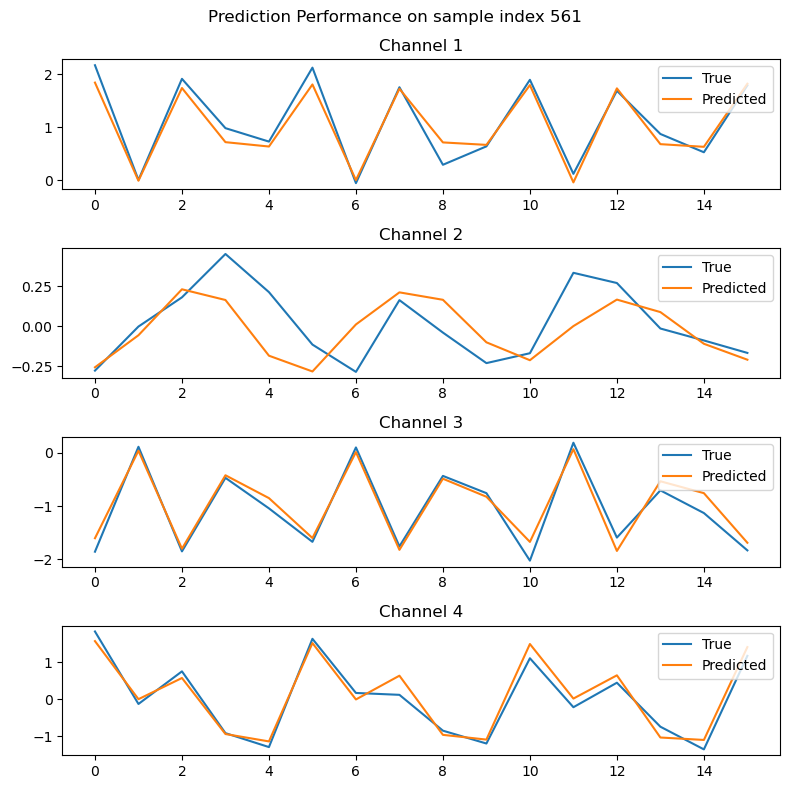

In [6]:
# 可视化预测结果
sample_index=np.random.choice(test_indices, 1)[0]  # 从测试集中随机选择1个样本进行预测
Y_predicted=model(torch.Tensor(X[sample_index]).view(1, input_len, input_channels)).detach().numpy().reshape(output_len, output_channels)
Y_to_predict=Y[sample_index]

mse=np.mean((Y_predicted-Y_to_predict)**2)
print(f"MSE on sample {sample_index}: {mse:.4f}")


# 作图
plt.figure(figsize=(8, 2*output_channels))
plt.suptitle("Prediction Performance on sample index {}".format(sample_index))
for i in range(output_channels):
    plt.subplot(output_channels, 1, i+1)
    plt.title(f"Channel {i+1}")
    plt.plot(Y_to_predict[:,i], label='True')
    plt.plot(Y_predicted[:,i], label='Predicted')
    plt.legend(['True', 'Predicted'], loc='upper right')

plt.tight_layout() # 调整子图间距，防止重叠
plt.bbox_inches='tight' # 确保保存时图片不丢失边界区域
# plt.savefig('performance.png', dpi=300) # 保存图片
plt.show()


100%|██████████| 1000/1000 [00:03<00:00, 314.06it/s]


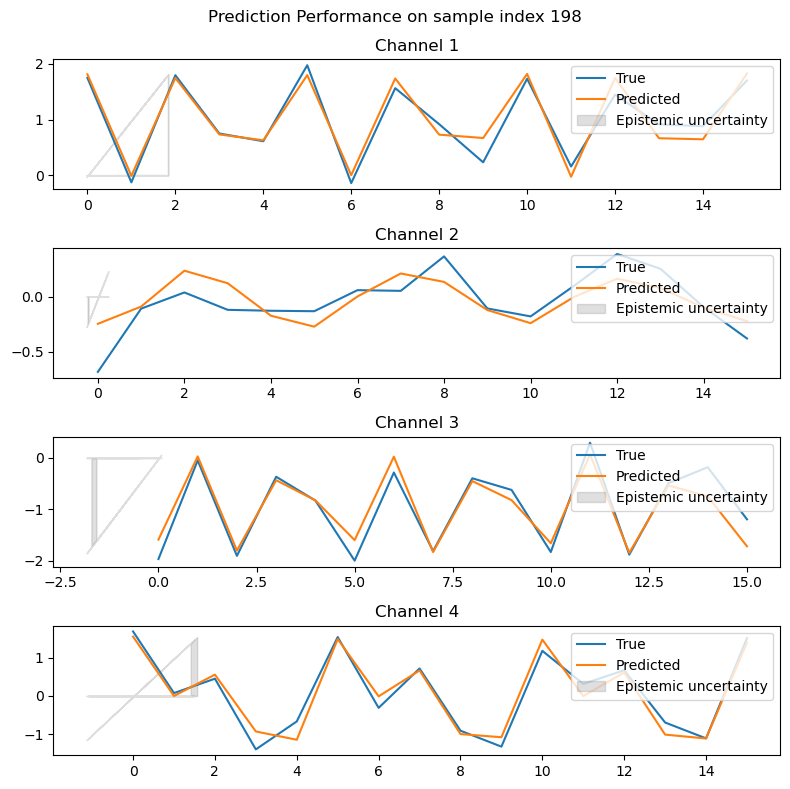

In [7]:

# 可视化预测不确定性
num_experiments= 1000 # 对于同一输入的预测次数
# 可视化预测结果
sample_index=np.random.choice(test_indices, 1)[0]  # 从测试集中随机选择1个样本进行预测
X_to_predict=torch.Tensor(X[sample_index]).view(1, input_len, input_channels) # X_to_predict: (1, input_len, input_channels)
Y_predicted_list=[]
for i in tqdm.tqdm(range(num_experiments)):
    Y_predicted=model(X_to_predict).detach().numpy().reshape(output_len, output_channels) # Y_predicted: shape: (output_len, output_channels); type: numpy.ndarray
    Y_predicted_list.append(Y_predicted)
Y_predicted_list=np.array(Y_predicted_list) # Y_predicted_list: (num_experiments, output_len, output_channels)
Y_to_predict=Y[sample_index] # Y_to_predict: shape: (output_len, output_channels); type: numpy.ndarray


y_sigma = np.std(Y_predicted_list, axis=0)
y_mean = np.mean(Y_predicted_list, axis=0)

# 作图
plt.figure(figsize=(8, 2*output_channels))
plt.suptitle("Prediction Performance on sample index {}".format(sample_index))
for i in range(output_channels):
    plt.subplot(output_channels, 1, i+1)
    plt.title(f"Channel {i+1}")
    plt.plot(Y_to_predict[:,i], label='True')
    plt.plot(Y_predicted[:,i], label='Predicted')
    plt.fill_between(y_mean[:,i] + 2 * y_sigma[:,i],  y_mean[:,i] - 2 * y_sigma[:,i], alpha=0.25, color='gray', label='Epistemic uncertainty')
    plt.legend(['True', 'Predicted', 'Epistemic uncertainty'], loc='upper right')

plt.tight_layout() # 调整子图间距，防止重叠
plt.bbox_inches='tight' # 确保保存时图片不丢失边界区域
# plt.savefig('performance.png', dpi=300) # 保存图片
plt.show()

